In [6]:
# ------------------------------------------------- #
#  
#  SUBMIT SCRIPT FOR RANDOM MEASUREMENT BASED EHT SCHEME
#  Niklas Mueller, Joseph A. Carolan, Andrew Connelly, Zohreh Davoudi, Eugene F. Dumitrescu, Kübra Yeter-Aydeniz
#  arXiv:2210.03089
#
# Copyright 2023 Niklas Mueller, Joseph A. Carolan, Andrew Connelly, Zohreh Davoudi, Eugene F. Dumitrescu, Kübra Yeter-Aydeniz
# 
# Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the “Software”), 
# to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, 
# and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:
# 
# The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.
# 
# THE SOFTWARE IS PROVIDED “AS IS”, WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, 
# FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER 
# LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS 
# IN THE SOFTWARE.
# 
# ------------------------------------------------- #

import sys
import os
import numpy as np
np.set_printoptions(precision=4)
import pickle
import matplotlib.ticker as ticker
import math
import scipy
from scipy.stats import unitary_group
from qiskit import *
from qiskit.result import marginal_counts
from qiskit.providers.ibmq.job import job_monitor
from qiskit.tools.visualization import plot_histogram
from qiskit import transpile
import qiskit.quantum_info as qi
from qiskit.visualization import plot_histogram
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import INCLUDE.basic
import INCLUDE
from INCLUDE.basis_transformations import Bogoliubov_staggered_mom_to_particle_antiparticle
from INCLUDE.basis_transformations import SFFFT_mom_to_pos
from INCLUDE.basis_transformations import quench_gate
from INCLUDE.physics import dispersion
from INCLUDE.interactions import compute_couplings
from INCLUDE.interactions import interaction_part_controlled
from INCLUDE.interactions import interaction_part

# use this for AER simulator
from qiskit.providers.aer import QasmSimulator
# use this for IONQ simulator and devices
# from qiskit_ionq import IonQProvider
# use this for IONQ simulator and devices via Microsoft Azure
# from azure.quantum.qiskit import AzureQuantumProvider

In [7]:
# ------------------------------------------------- #
#  Parameters
# ------------------------------------------------- #
N = 4            # lattice sites
N_A = N//2       # subsystem size
m = 0.9          # mass
n_shots = 1000   # shots
T = 0.0           # time evolution to T
RunName = "your_run_name"   # optional give a custom run name
N_ensemb=25                 # number of CUE ensembles
CUE_Strategy='NonEqualTime' # choose Simple or NonEqualTime, if NonEqualTime, the same random rotations
                            # are used at every T, this allows to compute non-equal time observables 


# ------------------------------------------------- #
#  BACKEND
# ------------------------------------------------- #
run_backend = 'AER'       # choose backend

# ------------------------------------------------- #
#  PROVIDER
# ------------------------------------------------- #
my_provider='NONE'       # choose provider

In [8]:
# -------------------------------------------------- #
#  AER SIMULATOR 
# -------------------------------------------------- #
if run_backend=='AER':
    my_backend = BasicAer.get_backend('qasm_simulator')
    
# -------------------------------------------------- #
#  OTHER PROVIDER 
# -------------------------------------------------- #
# elif run_backend=='XXXX' :
#     if my_provider == 'YYY':
    
            
print("# this job will run on",my_backend)

# this job will run on qasm_simulator


In [9]:
# ------------------------------------------------------------------------------ #
#  DATA OUTPUT
# ------------------------------------------------------------------------------ #
folder_save='EHT_RealTime_'+my_provider+'_'+RunName+'_'+str(my_backend)+'_N-'+str(N)+'_m-'+str(m)+'_T-'+str(T)+'_shots-'+str(n_shots)+'_ens-'+str(N_ensemb)

if not os.path.exists(folder_save):
    os.makedirs(folder_save)
    
print("# writing to",folder_save)

# writing to EHT_RealTime_NONE_your_run_name_qasm_simulator_N-4_m-0.9_T-0.0_shots-1000_ens-25


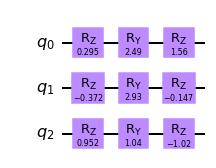

In [10]:
# ************************************************************************ #
#
# Circuits for local CUE rotations
#
# ************************************************************************ #
def angles_from_untary(U):
    U1=U[0,0]
    U2=U[0,1]
    
    theta1 = np.real( math.atan(-1j*(np.conj(U1)-U1)/(np.conj(U1)+U1)) - math.atan(-1j*(np.conj(U2)-U2)/(np.conj(U2)+U2))  )
    theta2 = np.real( 2.0*math.atan( np.sqrt( ((np.abs(U2))**2) / ((np.abs(U1))**2) )  ) )
    theta3 = np.real( math.atan(-1j*(np.conj(U1)-U1)/(np.conj(U1)+U1)) + math.atan(-1j*(np.conj(U2)-U2)/(np.conj(U2)+U2))  )
    
    return theta1,theta2,theta3
    
def random_CUE(N,dagger=False,CUEstrategy='Simple'):
    qcirc = qiskit.QuantumCircuit(N,name="CUE")
    
    angles = np.zeros((N,3),float)

    for n in range(N):
        U = unitary_group.rvs(2)
        theta1,theta2,theta3=angles_from_untary(U) 

        angles[n,0]=theta1
        angles[n,1]=theta2
        angles[n,2]=theta3

        qcirc.rz(theta1,n)
        qcirc.ry(theta2,n)
        qcirc.rz(theta3,n)

    
    if dagger==True:
        return qcirc.inverse(),angles
    return qcirc, angles


def CUE_from_angles(N,my_angles,dagger=False,CUEstrategy='Simple'):
    qcirc = qiskit.QuantumCircuit(N,name="CUE")

    for n in range(N):
        qcirc.rz(my_angles[n][0],n)
        qcirc.ry(my_angles[n][1],n)
        qcirc.rz(my_angles[n][2],n)

    if dagger==True:
        return qcirc.inverse(),qi.Operator(qcirc.inverse().data)

    return qcirc,qi.Operator(qcirc).data
 
mcirc,mangles = random_CUE(3,CUEstrategy='Advanced')
mcirc.draw('mpl')

In [11]:
# load angles for random CUE rotations, if the same rotations are used for every T
# otherwise generate them randomly

if CUE_Strategy == 'NonEqualTime' and T>0.0:
    
    rec_CUE_angles = np.zeros(N_ensemb,object)
    
    folder_CUE = 'EHT_RealTime_'+my_provider+'_'+RunName+'_'+str(my_backend)+'_N-'+str(N)+'_m-'+str(m)+'_T-'+str(0.0)+'_shots-'+str(n_shots)+'_ens-'+str(N_ensemb)+'_CUENonEqualTime'
    print("# loading angles from",folder_CUE)
    
    with open(folder_CUE+'/job_list') as file:
        lines = file.readlines()
        lines = [line.rstrip() for line in lines]

    job_list_CUE = lines
    
    # load random unitaries
    for i_ens in range(N_ensemb):
        filename_CUE_load=folder_CUE+'/CUE_angles-'+str(i_ens)+'_id-'+str(job_list_CUE[i_ens])
        file_CUE = open(filename_CUE_load, 'rb') 
        rec_CUE_angles[i_ens] = pickle.load(file_CUE)
        file_CUE.close()

In [12]:
# ------------------------------------------------------------------------------ #
# Create CUE circuits
# ------------------------------------------------------------------------------ #
def Create_Circut(i_ens):

    my_N = N
    my_T = T
        
    circ = QuantumCircuit(my_N,my_N)
    qubits = [j for j in range(my_N)]
    
    # CIRCUIT **************************************************************************************************** #
    
    # Ground state --------------------------------------- #
    # all particle and antiparticle un-occupied (| 1 > state)
    for q in range(my_N//2):
        circ.x(2*q)
        circ.x(2*q+1)
    # END Ground state ------------------------------------ #
    
    # for finite T, do actual time evolution -------------------------------------- #
    if T > 0.0:
        # quench (m --> -m) ----------------------------------- #
        circ.append(quench_gate(my_N, np.abs(m)),qubits)
        # END quench ------------------------------------------ #
    
        # time evolution -------------------------------------- #
        for q in range(my_N // 2):
            w_q = dispersion(q-my_N//4, my_N, np.abs(m))
            circ.rz(w_q * my_T,  2 * q)
            circ.rz(w_q * my_T,   2 * q + 1)
        # END time evolution ---------------------------------- #
        
        # Bogoliubov from (anti-)particle to even/odd --------- #
        circ.append(INCLUDE.basis_transformations.Bogoliubov_staggered_mom_to_particle_antiparticle(my_N, -m,  dagger=True), qubits)
        # END Bogoliubov -------------------------------------- #
    # END for finite T, do actual time evolution ------------------------------------ #  
        
    # for T=0 this is the same as simply preparing initial state ------------- #
    elif T==0.0:
        # Bogoliubov from (anti-)particle to even/odd --------- #
        circ.append(INCLUDE.basis_transformations.Bogoliubov_staggered_mom_to_particle_antiparticle(my_N, m,  dagger=True), qubits)
        # END Bogoliubov -------------------------------------- # 
    # END for T=0 ------------------------------------------------------------------- #
    
    # Fourier transform ----------------------------------- #
    circ.append(INCLUDE.basis_transformations.SFFFT_mom_to_pos(my_N, dagger=False), qubits)
    # END Fourier transform ------------------------------- #
    
    # END CIRCUIT ********************************************************************************************* #
    
    # SIMULATOR ONLY --------------------------- #
    if run_backend=='AER' and i_ens==0:
        
        systemA = np.arange(N//2).tolist()
        systemB = np.arange(N//2,N).tolist()
        
        rho_AB = qi.DensityMatrix.from_instruction(circ)
        rho_A = qi.partial_trace(rho_AB,systemB)  
        myRDM=rho_A.to_operator().data
        myDM=rho_AB.to_operator().data
    # ------------------------------------------ #
        
    # RANDOM MEASUREMENTS ******************************************************************************************
    if CUE_Strategy == 'NonEqualTime' and my_T>0.0:
        my_CUE_angles = rec_CUE_angles[i_ens]
        my_CUE_circ,temp_data = CUE_from_angles(my_N,my_CUE_angles,dagger=False,CUEstrategy='NonEqualTime')
        circ.append(my_CUE_circ,qubits)
    else:
        my_CUE_circ,my_CUE_angles = random_CUE(N,CUEstrategy=CUE_Strategy)
        circ.append(my_CUE_circ,qubits)

    for j in range(N):
        circ.measure(j,j)
    # EMD RANDOM MEASUREMENTS ***************************************************************************************
    
    if run_backend=='AER' and i_ens==0:
        return circ, my_CUE_circ, my_CUE_angles, myDM, myRDM
    else: 
        return circ, my_CUE_circ, my_CUE_angles 

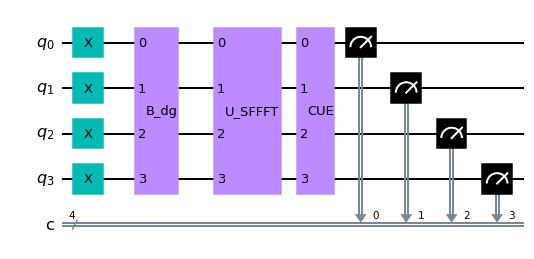

In [14]:
# ------------------------------------------------------------------------------ #
# Create circuits
# ------------------------------------------------------------------------------ #

CUE_angles = np.zeros(N_ensemb,object)
CUE_circ = np.zeros(N_ensemb,object)
quantum_circuits =  np.zeros(N_ensemb,object)


for i_ens in range(N_ensemb):
    if run_backend=='AER' and i_ens==0:
        quantum_circuits[i_ens], CUE_circ[i_ens], CUE_angles[i_ens], DM, RDM = Create_Circut(i_ens)
    else:
        quantum_circuits[i_ens], CUE_circ[i_ens], CUE_angles[i_ens] = Create_Circut(i_ens)

if run_backend=='AER':
    filename_RDM=folder_save+'/RDM'
    file_RDM = open(filename_RDM, 'wb') 
    pickle.dump(RDM, file_RDM)
    file_RDM.close()

    filename_DM=folder_save+'/DM'
    file_DM = open(filename_DM, 'wb') 
    pickle.dump(DM, file_DM)
    file_DM.close()
    
quantum_circuits[0].draw('mpl')

In [17]:
# ------------------------------------------------------------------------------ #
# Submit circuits
# ------------------------------------------------------------------------------ #
transpiled = np.zeros(N_ensemb,object)
job_list = np.zeros(N_ensemb,object)
sim_probab = np.zeros((N_ensemb,2**N),float)
sim_probab_N_A = np.zeros((N_ensemb,2**N_A),float)
counts=np.zeros(N_ensemb,object)

# loop over CUE ensembles ------------------------------------------------------------------ #
for i_ens in range(N_ensemb):
    # ------------------------------------------------------------------------------ #
    #  RUN JOB
    # ------------------------------------------------------------------------------ #
    if run_backend=='AER':
        simp_job = execute(quantum_circuits[i_ens], backend=my_backend, shots=n_shots)
        
        filename_result=folder_save+'/result_ens-'+str(i_ens)+'_id-'+str(simp_job.job_id())
        file_result = open(filename_result, 'wb') 
        pickle.dump(simp_job.result(), file_result)
        file_result.close()
        
        counts[i_ens] = marginal_counts(simp_job.result(), indices=[j for j in range(N)]).get_counts()

        for key in counts[i_ens]:
            mystr=key
            s=0
            for i in range(N):
                s+=int(mystr[N-1-i])*(2**(i))
            sim_probab[i_ens][s] = counts[i_ens][key]/n_shots

        for s in range(2**N):
            s_N_A = s&(2**N_A - 1)
            sim_probab_N_A[i_ens][s_N_A] += sim_probab[i_ens][s]
            
        filename_P=folder_save+'/simulator_P-'+str(i_ens)+'_id-'+str(simp_job.job_id())
        file_P = open(filename_P, 'wb') 
        pickle.dump(sim_probab[i_ens],file_P)
        file_P.close()
        
#     elif run_backend=='XXXX':
#         transpiled[i_ens] = transpile(quantum_circuits[i_ens], my_backend)
#         simp_job = my_backend.run(transpiled[i_ens], shots=n_shots)
         
    #  END run job ------------------------------------------------------------------ #

    # ------------------------------------------------------------------------------ #
    # Print INFO
    # ------------------------------------------------------------------------------ #
    print(simp_job.job_id())
    print(simp_job.status())
    job_list[i_ens] = simp_job.job_id()
    #  END print INFO -------------------------------------------------------------- #

    # Write circuit to file
    filename_circuit=folder_save+'/circuit-'+str(i_ens)+'_id-'+str(simp_job.job_id())
    file_circuit = open(filename_circuit, 'wb') 
    pickle.dump(quantum_circuits[i_ens], file_circuit)
    file_circuit.close()

    # write transpiled circuit to file (XXX only)
 #   if run_backend=='XXXX':
#         filename_transp_circuit=folder_save+'/transp_circuit-'+str(i_ens)+'_id-'+str(simp_job.job_id())
#         file_transp_circuit = open(filename_transp_circuit, 'wb') 
#         pickle.dump(transpiled[i_ens], file_transp_circuit)
#         file_transp_circuit.close()
        
    # write random unitaries to file
    filename_CUE=folder_save+'/CUE_angles-'+str(i_ens)+'_id-'+str(simp_job.job_id())
    file_CUE = open(filename_CUE, 'wb') 
    pickle.dump(CUE_angles[i_ens], file_CUE)
    file_CUE.close()
    
    # write parameters to file
    if i_ens ==0:
        filename_params=folder_save+'/params'
        file_params = open(filename_params, "w")
        if run_backend=='AER':
            file_params.write("N\t"+str(N)+"\nm\t"+str(m)+"\nT\t"+str(T)+"\nn_shots\t"+str(n_shots)+"\nensmbles\t"+str(N_ensemb)+"\nbackend\t"+str(run_backend)+"\n")
#         elif run_backend=='XXXX':
#             ####
        file_params.close()
        
# END loop over all CUE ensembles ----------------------------------------------------------------- #

with open(folder_save+'/job_list', 'w') as f:
    for row in job_list:
        f.write("%s\n" % row)
        

6c7eb020-307e-4024-8723-f264dff01cd8
JobStatus.DONE
6c2d22c4-f173-4df8-bb31-10f81dfcc2e3
JobStatus.DONE
466f917e-965a-4689-8284-4a791715c906
JobStatus.DONE
481652c6-7547-4cfe-839e-643541370945
JobStatus.DONE
feadde34-ad46-4c8a-b4b2-26168270c7bf
JobStatus.DONE
79275935-5a3f-4737-a9e6-dce9932f3189
JobStatus.DONE
e81dd99c-9931-4fbf-8939-98d61acfcaa7
JobStatus.DONE
65a35c37-36c1-4446-8e71-7975d515dfea
JobStatus.DONE
8b29ced7-7c06-4434-afa4-958231d7f511
JobStatus.DONE
229b5dc0-c8dd-4d19-b35f-32fa2126e115
JobStatus.DONE
f736e433-8bdb-4c98-b60d-ac9044df115e
JobStatus.DONE
d3111444-d051-45ac-8445-2630e2e96f83
JobStatus.DONE
a20f6697-a2ff-4ebf-b7da-875306361a2c
JobStatus.DONE
1d8a4b4e-ef82-4f4e-b23f-8a6ebc219523
JobStatus.DONE
18271177-9939-463a-be56-0a3c93b5e79e
JobStatus.DONE
dee9f4e8-61c4-45e6-8b8f-44d252e0aa5b
JobStatus.DONE
8e21480c-1a44-440b-932d-e34eb6a2dc76
JobStatus.DONE
a5081fd0-1706-4c0b-88a2-c4d9f1d89f42
JobStatus.DONE
80a1e6ef-261c-4a9d-b811-db3b4f270bac
JobStatus.DONE
db149dc3-5d0